In [1]:

import pandas as pd
import numpy as np

import os

from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             matthews_corrcoef, accuracy_score)
from sklearn.metrics import precision_recall_curve, average_precision_score

from loguru import logger
from collections import defaultdict
import pandas as pd

from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# PREDICTION_FILENAME = "/home/zengs/data/Code/reproduce/protgps/test_runs/inference/prediction.csv"
# output_img_filename = os.path.join("/home/zengs/data/Code/reproduce/protgps/test_runs/inference", "protGPS_inference.png")

predict_dir = "/home/zengs/data/Code/reproduce/protgps/test_runs/finetune-26epoch"
PREDICTION_FILENAME = f"{predict_dir}/prediction.csv"
output_img_filename = os.path.join(predict_dir, "SFT.png")

LABEL_COLS = ['TRANSCRIPTIONAL',
 'CHROMOSOME',
 'NUCLEAR_PORE_COMPLEX',
 'NUCLEAR_SPECKLE',
 'P-BODY',
 'PML-BDOY',
 'POST_SYNAPTIC_DENSITY',
 'STRESS_GRANULE',
 'NUCLEOLUS',
 'CAJAL_BODY',
 'RNA_GRANULE',
 'CELL_JUNCTION']

PRED_COLS = [ f"{col}_Score" for col in LABEL_COLS] 

In [3]:
prediction_df = pd.read_csv(PREDICTION_FILENAME)


In [4]:
def calculate_metrics(y_true, y_pred, y_prob = None):
  """
  Calculate metrics for multi-label classification.

  Parameters:
  y_true (ndarray): True binary labels in binary format, 
    shape (n_samples, n_classes)
  y_pred (ndarray): Predicted binary labels, shape (n_samples, n_classes)
  y_prob (ndarray): Predicted probabilities, shape (n_samples, n_classes)

  Returns:
  dict: Dictionary containing AUC, AUPR, Precision, Recall, F1, MCC 
    for each class
  """
  n_classes = y_true.shape[1]
  metrics = {"auc": [],
             "aupr": [],
             "precision": [],
             "recall": [],
             "f1": [],
             "mcc": []}

  metrics["precision"] = precision_score(y_true, y_pred, average=None,
                                         zero_division=np.nan)
  metrics["recall"] = recall_score(y_true, y_pred, average=None,
                                   zero_division=np.nan)
  metrics["f1"] = f1_score(y_true, y_pred, average=None,
                           zero_division=np.nan)
  
  metrics["micro_f1"] = precision_score(y_true, y_pred, average='micro',
                           zero_division=np.nan)    
  metrics["micro_f1"] = recall_score(y_true, y_pred, average='micro',
                           zero_division=np.nan)  
  metrics["micro_f1"] = f1_score(y_true, y_pred, average='micro',
                           zero_division=np.nan)

  for i in range(n_classes):
    y_true_i = y_true[:, i]
    y_pred_i = y_pred[:, i]
    y_prob_i = y_prob[:, i]

    # Calculate AUC
    try:
      auc = np.nan
      aupr = np.nan
      mcc = np.nan
      
      if len(np.unique(y_true_i)) > 1:
        if y_prob is not None:
          auc = roc_auc_score(y_true_i, y_prob_i)
          aupr = average_precision_score(y_true_i, y_prob_i)
        mcc = matthews_corrcoef(y_true_i, y_pred_i)

    except ValueError as e:
        auc = np.nan
        aupr = np.nan
        mcc = np.nan
        logger.warning(f"Error calculating AUC, AUPR, MCC: {e}")

    metrics["auc"].append(auc)
    metrics["aupr"].append(aupr)
    metrics["mcc"].append(mcc)

  metrics_mean = {k: np.nanmean(v) for k, v in metrics.items()}

  return metrics, metrics_mean

In [5]:
def find_best_threshold_multi_label(y_true, y_pred_prob):
    """
    Find the best threshold for each label based on F1 score.
    
    Parameters:
    - y_true: (n_samples, n_labels) Binary ground truth labels
    - y_pred_prob: (n_samples, n_labels) Predicted probabilities

    Returns:
    - best_thresholds: List of best thresholds for each label
    """
    best_thresholds = []
    
    for i in range(y_true.shape[1]):
      masked_targets = y_true[:, i]
      masked_probs = y_pred_prob[:, i]
      precision, recall, thresholds_pr = precision_recall_curve(masked_targets, masked_probs)
      with np.errstate(invalid='ignore'):
        f1_scores = np.where((precision + recall) ==0,
                            0,
                            2 * precision * recall / (precision + recall))
      optimal_idx_pr = np.argmax(f1_scores)
      one_best_threshold = thresholds_pr[optimal_idx_pr]
      best_thresholds.append(one_best_threshold)

    return best_thresholds

In [6]:

valid_df = prediction_df[(prediction_df.split == "train") | (prediction_df.split == "dev")]
# valid_df = prediction_df[ (prediction_df.split == "dev")]
true_labels = valid_df[LABEL_COLS].values
prob_labels = valid_df[PRED_COLS].values
best_th = find_best_threshold_multi_label(true_labels, prob_labels)

performance_df = defaultdict(list)
mean_performance_df = defaultdict(list)
for dataset_name, one_prediction_df in prediction_df.groupby("split"):
  
  # print(one_prediction_df[PRED_COLS].values)
  
  true_labels = one_prediction_df[LABEL_COLS].values
  prob_labels = one_prediction_df[PRED_COLS].values
  pred_labels = (prob_labels > best_th).astype(int)

  metrics, metrics_mean = calculate_metrics(true_labels, pred_labels, prob_labels)
  
  for name, values in metrics.items():
    if isinstance(values, list) or isinstance(values, np.ndarray):
      performance_df["split"].extend([dataset_name] * len(values))
      performance_df["metrics_name"].extend([name] * len(values))
      performance_df["location"].extend(LABEL_COLS)
      performance_df["values"].extend(values)
    
  for name, value in metrics_mean.items():
    mean_performance_df["split"].append(dataset_name)
    mean_performance_df["metrics_name"].append(name)
    mean_performance_df["values"].append(value)

location_performance_df = pd.DataFrame(performance_df)
mean_performance_df = pd.DataFrame(mean_performance_df)


custom_order = {'train': 0, 'dev': 1, 'test': 2}



mean_performance_df['category_order'] = mean_performance_df['split'].map(custom_order)
mean_performance_df = mean_performance_df.sort_values('category_order').drop(columns=['category_order'])

location_performance_df['category_order'] = location_performance_df['split'].map(custom_order)
location_performance_df = location_performance_df.sort_values('category_order').drop(columns=['category_order'])

In [7]:
mean_performance_df[mean_performance_df.metrics_name == "mcc"].values

res = ""
for onerow in mean_performance_df[mean_performance_df.metrics_name == "mcc"].values:
  res += f"{onerow[0]}: {onerow[2]:.3f}; "

res

'train: 0.519; dev: 0.479; test: 0.430; '

/tmp/ipykernel_1584725/2820199542.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


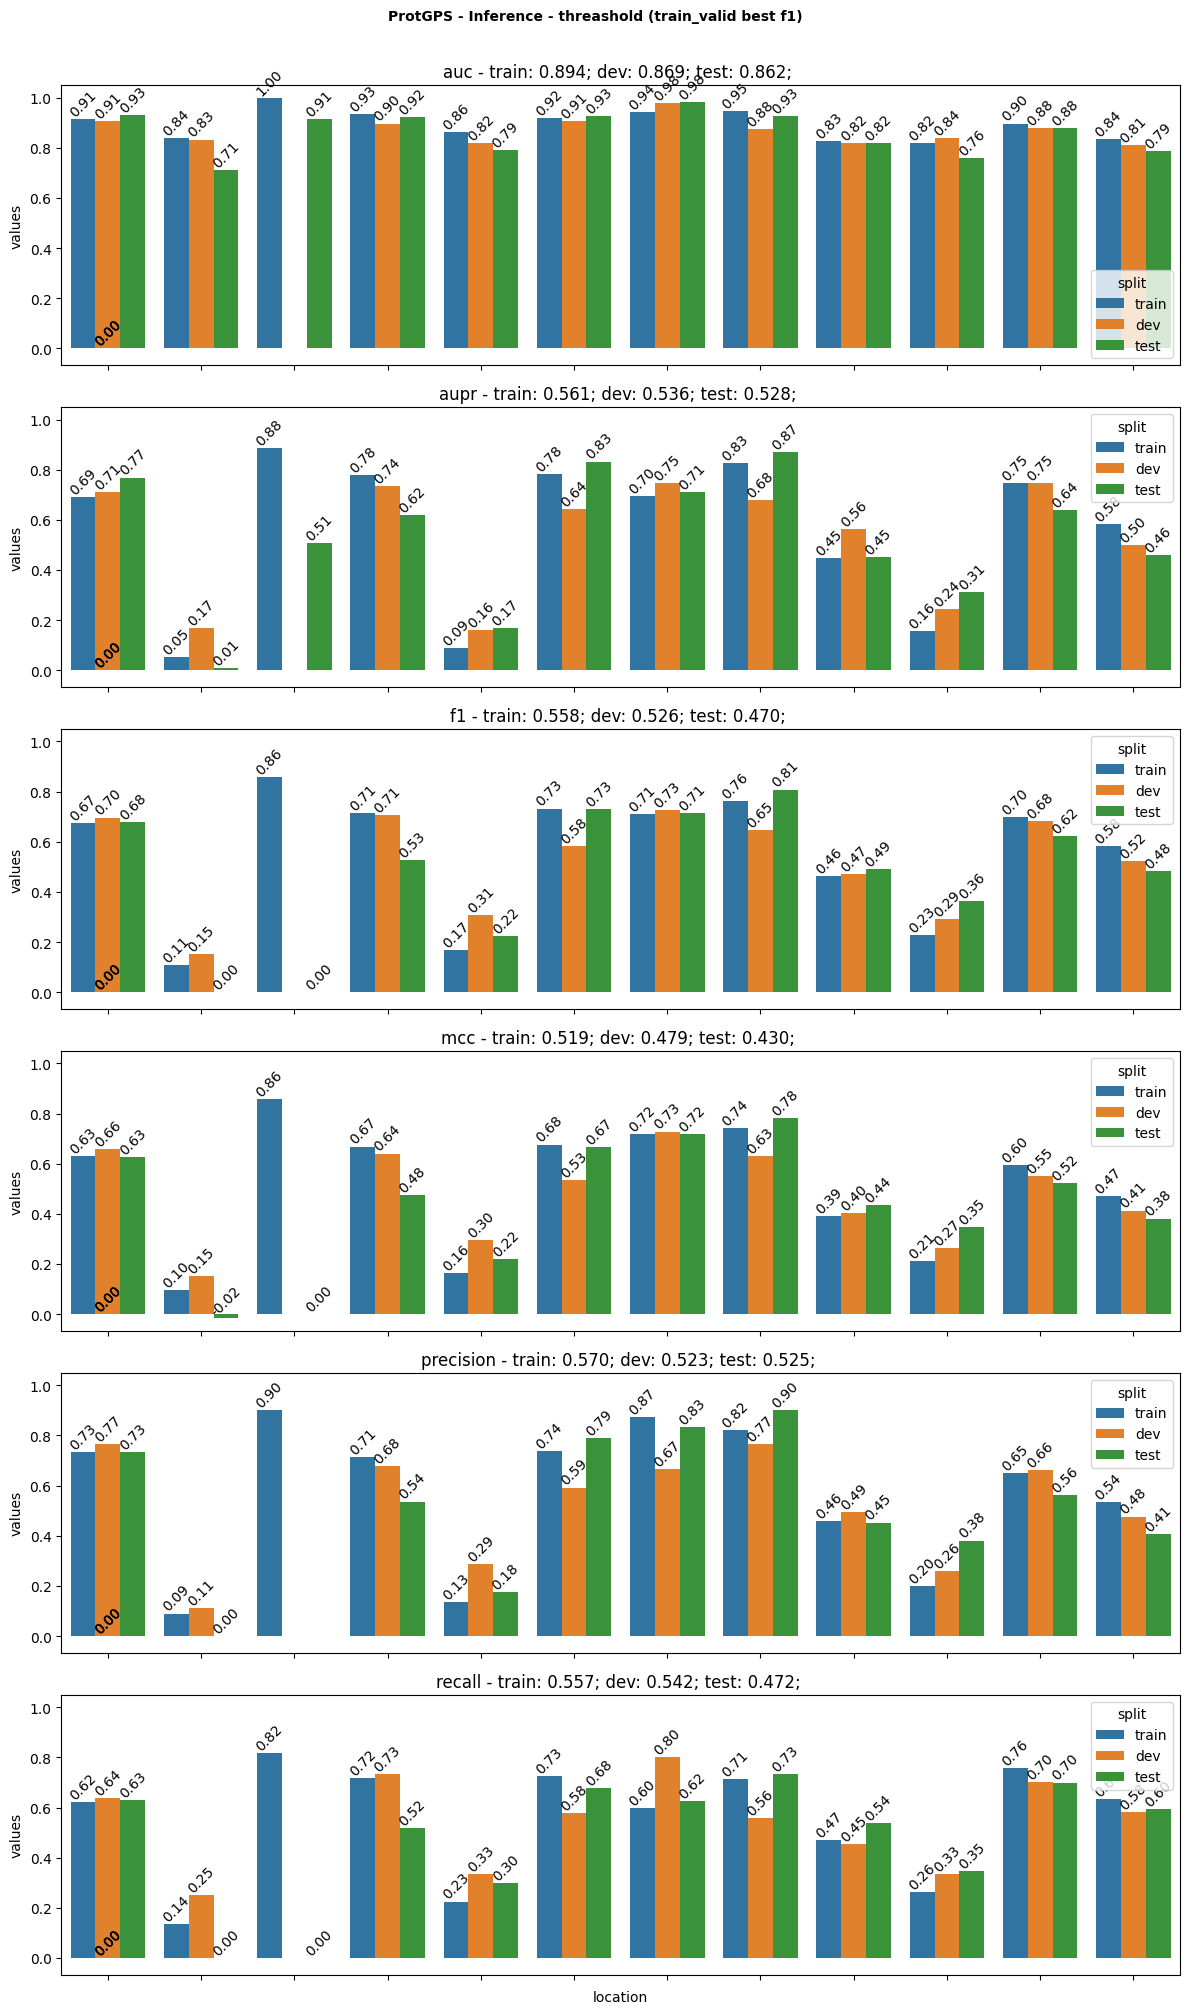

In [8]:
# Create subplots
unique_metrics = location_performance_df["metrics_name"].unique()
fig, axes = plt.subplots(len(unique_metrics), 1, figsize=(12, 20), sharex=True, sharey=True)

# Ensure axes is iterable even if there's only one metric
if len(unique_metrics) == 1:
    axes = [axes]

# Loop through each metric and plot
for ax, (metrics_name, one_metrics_df) in zip(axes, location_performance_df.groupby("metrics_name")):
    sns.barplot(data=one_metrics_df, x="location", y="values", hue="split", ax=ax)
    
    res = ""
    for onerow in mean_performance_df[mean_performance_df.metrics_name == metrics_name].values:
      res += f"{onerow[0]}: {onerow[2]:.3f}; "
    
    # Show values above bars
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2,  # X position
                p.get_height(),  # Y position (above the bar)
                f'{p.get_height():0.2f}',  # Value text
                ha='center', va='bottom', fontsize=10, color='black', rotation=45)  # Rotate text

    ax.set_title(f"{metrics_name} - {res}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

fig.suptitle("ProtGPS - Inference - threashold (train_valid best f1)", fontsize=10, fontweight='bold', y=1.005)
plt.tight_layout()  # Adjust layout


plt.savefig(output_img_filename, dpi=200, bbox_inches="tight")
plt.show()